# TVB simulations in nipype with #the_nipype_pals


## The Virtual Brain simulates brain dynamics with neural mass models

## User inputs structural connectivity + local and global parameters to the models

__Example: The Wilson-Cowan Model:__
$$\tau\frac{dE_j}{dt} = (S_{e_max} - E_j(t))S_e(c_1 E_j(t) - c_2 I_j(t) + c_5 \sum_{k}A_{jk}E_k(t-\tau_d^k) + P_j(t)) + \sigma w_j(t)$$

$$\tau\frac{dI_j}{dt} = -I_j(t) + (S_{i_max} - I_j(t)) S_i (c_3 E_j(t) - c_4 I_j(t)) + \sigma v_j(t)$$

## Functional connectivity is computed based on inputs

<img src="presentation-image.png" alt="drawing" style="height:750px;"/>

## Simulations can be slow because:

### - Lots of parcellated regions to simulate
### - Numerous subject specific DTI to input into 1 model
### - Exploration of the model requires simulation for each parameter value

## Let's speed this up by Nipype-tting all the simulations!

# Nipype-tting TVB into workflows

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os, sys, scipy.io, numpy as np
from nipype import Node, Function, Workflow
cwd = os.getcwd()

__Each Nipype node functions within its own environment__

In [3]:
# https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html
def make_model(model_name, parameters):# done
    import warnings, pickle, os
    warnings.filterwarnings('ignore')
    from tvb.simulator.lab import models
    import numpy as np
    mod = getattr(models, model_name)
    model_class = mod(**dict(parameters))
    with open("model_class.p", "wb") as f:
        pickle.dump(model_class, f)
    model_class = os.path.abspath("model_class.p")
    return model_class

### Load structural connectivity files

In [4]:
def load_connectivity_mat(in_file, normalize=False):
    import scipy.io, pickle, os
    datamat = scipy.io.loadmat(in_file)
    sc_weights = datamat['sc_weights']
    if normalize:
        sc_weights = sc_weights / sc_weights.max()
    tract_lengths = datamat['tract_lengths']
    scipy.io.savemat('sc_weights.mat',{'sc_weights': sc_weights})
    scipy.io.savemat('tract_lengths.mat',{'tract_lengths': tract_lengths})
    sc_weights = os.path.abspath("sc_weights.mat")
    tract_lengths = os.path.abspath("tract_lengths.mat")
    return sc_weights, tract_lengths
    
def make_connectivity(weights, lengths):
    import warnings, pickle, os, scipy.io
    warnings.filterwarnings('ignore')
    weights_mat = scipy.io.loadmat(weights); weights = weights_mat['sc_weights']
    lengths_mat = scipy.io.loadmat(lengths); lengths = lengths_mat['tract_lengths']
    from tvb.simulator.lab import connectivity
    conn_class = connectivity.Connectivity(weights=weights, tract_lengths=lengths)
    with open("conn_class.p", "wb") as f:
        pickle.dump(conn_class, f)
    conn_class = os.path.abspath("conn_class.p")
    return conn_class

### Make mathy and signaly stuff

In [5]:
def make_integrator(integrator_name, base_dt, noise_type, noise_val):
    import sys, numpy, warnings, pickle, os
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand 
    from tvb.simulator.lab import integrators, noise
    temp_integrator = getattr(integrators,integrator_name)
    temp_noise = getattr(noise, noise_type)
    noise = temp_noise(nsig = numpy.array([noise_val]))
    integrator_class = temp_integrator(dt = base_dt, noise = noise)
    #integrator_class = temp_integrator(dt = base_dt)
    with open("integrator_class.p", "wb") as f:
        pickle.dump(integrator_class, f)
    integrator_class = os.path.abspath("integrator_class.p")
    return integrator_class

def make_monitors(monitor_types, periods):
    import warnings, sys, numpy, pickle, os
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand
    from tvb.simulator.lab import monitors
        
    monitor_class = []
    for i in range(len(monitor_types)):
        monitor_tmp = getattr(monitors,monitor_types[i])
        monitor_tmp2 = monitor_tmp(period = periods[i])
        monitor_class.append(monitor_tmp2)
        
    monitor_class = tuple(monitor_class)
    with open("monitor_class.p", "wb") as f:
        pickle.dump(monitor_class, f)
    monitor_class = os.path.abspath("monitor_class.p")
    return monitor_class

## TVB is still stuck in python2, which isn't too compatible with nipype-tting
__Long story short: save node outputs as directory strings instead of actual objects__

In [6]:
def run_simulation(out_file, model_input, conn_input, integrator_input, monitor_input, global_coupling = 0.1, conduction_speed=3.0, simulation_length=10000.0):
    import warnings, sys, numpy, pickle, os, scipy.io
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand
    
    with open(model_input, "rb") as f:
        model_input = pickle.load(f)
    with open(conn_input, "rb") as f:
        conn_input = pickle.load(f)
    with open(integrator_input, "rb") as f:
        integrator_input = pickle.load(f)
    with open(monitor_input, "rb") as f:
        monitor_input = pickle.load(f)

    from tvb.simulator.lab import *
    wm_coupling = coupling.Linear(a = global_coupling)
    sim = simulator.Simulator(model = model_input, connectivity = conn_input, coupling = wm_coupling,
                             integrator = integrator_input, monitors = monitor_input,
                             simulation_length = simulation_length, conduction_speed = conduction_speed)
    
    sim.configure()
    sim_output = sim.run()
    scipy.io.savemat('sim_output.mat',{'sim_output': sim_output})
    abs_out_file = os.path.abspath("sim_output.mat") # fix this
    return abs_out_file

# Actually Nipype-tting

In [7]:
##### NIPYPE PORTION
# https://miykael.github.io/nipype_tutorial/notebooks/basic_function_interface.html
model = Node(
    Function(
        input_names=['model_name', 'parameters'],
        output_names=['model_class'],
        function=make_model
    ),
    name='create_model'
)
 
sc_loader = Node(
    Function(
        input_names=['in_file', 'normalize'],
        output_names=['sc_weights', 'tract_lengths'],
        function=load_connectivity_mat
    ),
    name='load_sc_mat'
)

sc = Node(
    Function(
        input_names=['weights', 'lengths'],
        output_names=['conn_class'],
        function=make_connectivity
    ),
    name='create_sc'
)

integrator = Node(
    Function(
        input_names=['integrator_name','base_dt','noise_type','noise_val'],
        output_names=['integrator_class'],
        function=make_integrator
    ),
    name='create_integrator'
)

monitors = Node(
    Function(
        input_names=['monitor_types','periods'],
        output_names=['monitor_class'],
        function=make_monitors
    ),
    name='create_monitors'
)

simulate = Node(
    Function(
        input_names=['out_file', 'model_input', 'conn_input', 'integrator_input', 'monitor_input',
                     'global_coupling', 'conduction_speed', 'simulation_length'],
        output_names=['abs_out_file'],
        function=run_simulation
    ),
    name='create_simulation'
)

In [8]:
from nipype.interfaces.io import DataSink
datasink = Node(
    DataSink(base_directory="/home/axiezai/neuroha2018/tvb_nipype/output",
                         container="datasink"),
                name="datasink")

## Connecting the workflow

In [10]:
# https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html
workflow = Workflow(name='tvb_demo', base_dir=os.getcwd())
workflow.connect([
    (model, simulate, [("model_class", "model_input")]),
    (sc_loader, sc, [("sc_weights", "weights"), ("tract_lengths", "lengths")]),
    (sc, simulate, [("conn_class", "conn_input")]),
    (integrator, simulate, [("integrator_class", "integrator_input")]),
    (monitors, simulate, [("monitor_class", "monitor_input")]),
    (model, datasink, [("model_class","model_class")]),
    (sc, datasink,[("conn_class","conn_class")]),
    (integrator, datasink,[("integrator_class","integrator_class")]),
    (monitors, datasink,[("monitor_class","monitor_class")])
    #(simulate, datasink,["abs_out_file","abs_out_file"])
])

# NOW DEFINE YOUR INPUTS
model.inputs.model_name = 'Generic2dOscillator'
model.inputs.parameters = [('a',1), ('b',1)]
sc_loader.inputs.in_file = os.path.join(cwd, 'input', 'sub-01_connectivity.mat')
sc_loader.inputs.normalize = False 
integrator.inputs.integrator_name = 'HeunStochastic'
integrator.inputs.base_dt = 0.1
integrator.inputs.noise_type = 'Additive'
monitors.inputs.monitor_types = ['Bold', 'TemporalAverage']
monitors.inputs.periods = [2000.0, 10.0]
simulate.inputs.out_file = os.path.join(cwd, 'tvb_test1.mat')
simulate.inputs.simulation_length = 10000.0

# ITERABLES
integrator.iterables = ("noise_val", [0.0001, 0.001, 0.01])
simulate.iterables = [('global_coupling', np.linspace(0.0, 1.5, 3)), ('conduction_speed', [1,2])]

# make datasink at the end to clean things up 
#def run_simulation(out_file, model_input, conn_input, integrator_input, monitor_input, global_coupling = 0.1, conduction_speed=2.0, simulation_length=1000.0):


## Take a look at our simple workflow graph:

In [11]:
# Write graph of type orig
workflow.write_graph(graph2use='exec', dotfilename='./graph_orig.dot')

180810-12:18:36,808 nipype.workflow INFO:
	 Generated workflow graph: /home/axiezai/neuroha2018/tvb_nipype/graph_orig.png (graph2use=exec, simple_form=True).


u'/home/axiezai/neuroha2018/tvb_nipype/graph_orig.png'

In [12]:
from IPython.display import HTML
HTML('<img src="NIRWSyo.gif">')

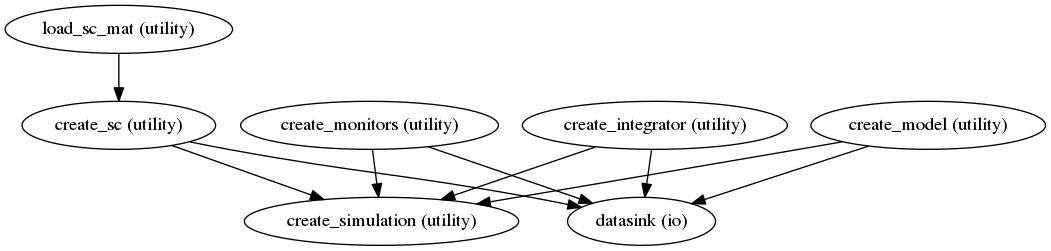

In [13]:
from IPython.display import Image
Image(filename="graph_orig.png")

In [14]:
HTML('<img src="https://media.giphy.com/media/2dJ5Iait4QrW8/giphy.gif">')

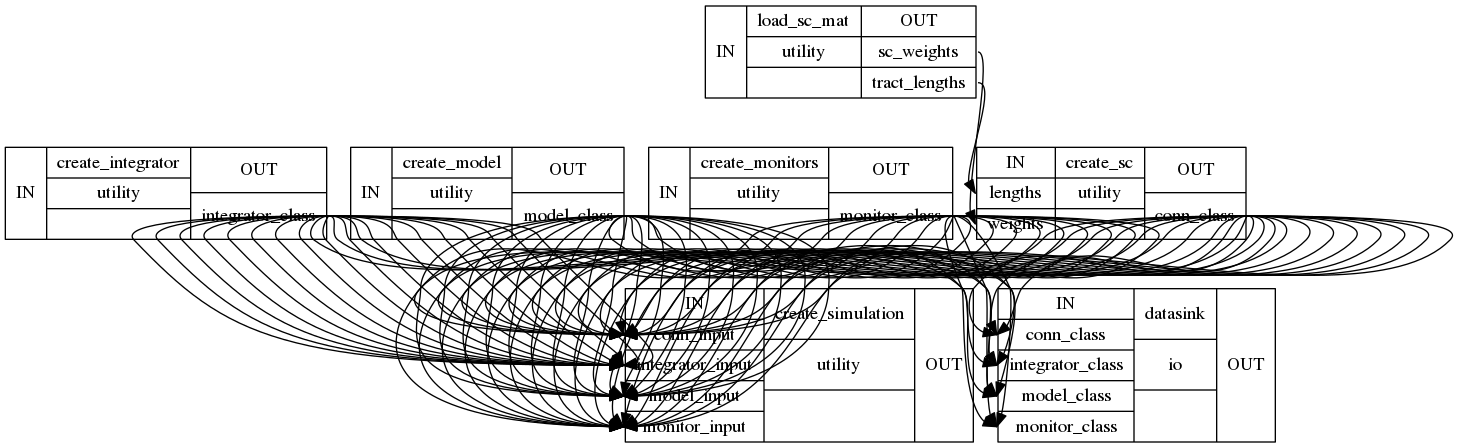

In [15]:
from IPython.display import Image
Image(filename="graph_orig_detailed.png")

In [16]:
HTML('<img src="https://media1.tenor.com/images/ed61af8075e98d35b79ddcbc66e23c7d/tenor.gif?itemid=9421746">')

# Let's run the workflow!

In [17]:
#workflow.run()
workflow.run('MultiProc', plugin_args={'n_procs': 8})

180810-12:18:45,263 nipype.workflow INFO:
	 Workflow tvb_demo settings: ['check', 'execution', 'logging', 'monitoring']
180810-12:18:45,300 nipype.workflow INFO:
	 Running in parallel.
180810-12:18:45,306 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 6.93/6.93, Free processors: 8/8.
180810-12:18:45,346 nipype.workflow INFO:
	 [Job 0] Cached (tvb_demo.create_integrator).
180810-12:18:45,350 nipype.workflow INFO:
	 [Job 1] Cached (tvb_demo.create_model).
180810-12:18:45,353 nipype.workflow INFO:
	 [Job 2] Cached (tvb_demo.create_integrator).
180810-12:18:45,357 nipype.workflow INFO:
	 [Job 3] Cached (tvb_demo.load_sc_mat).
180810-12:18:45,362 nipype.workflow INFO:
	 [Job 5] Cached (tvb_demo.create_monitors).
180810-12:18:45,367 nipype.workflow INFO:
	 [Job 20] Cached (tvb_demo.create_integrator).
180810-12:18:47,314 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 6.93/6.93, Free processors: 8/8.
180810-12

## Take a look at all the outputs:

In [19]:
!tree /home/axiezai/neuroha2018/tvb_nipype/output/

/home/axiezai/neuroha2018/tvb_nipype/output/
├── datasink
│   ├── conn_class
│   │   └── conn_class.p
│   ├── integrator_class
│   │   ├── _noise_val_0.0001
│   │   │   └── integrator_class.p
│   │   ├── _noise_val_0.001
│   │   │   └── integrator_class.p
│   │   └── _noise_val_0.01
│   │       └── integrator_class.p
│   ├── model_class
│   │   └── model_class.p
│   └── monitor_class
│       └── monitor_class.p
├── simtest1_sub-01_1.0_0.0001.mat
└── simtest1_sub-01_1.0_0.001.mat

8 directories, 8 files


# Thank you Neurohackademy! 
## Questions?
__Special thanks to Miykael, Ross, Kirstie, Tal, and Satra for helping the pals!__
<img src="grouppic.jpg" alt="drawing" style="height:750px;"/>